In [31]:
pip install matplotlib-venn


+------------+------------+---------------------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+----------------------------------+
| Modèle 1   | Modèle 2   |   Entités en Intersection |   Entités uniquement dans Spacy_lg |   Entités uniquement dans Spacy_sm |   Entités uniquement dans Flaubert |   Entités uniquement dans Camembert |   Entités uniquement dans Stanza |
+============+============+===========================+====================================+====================================+====================================+=====================================+==================================+
| Spacy_lg   | Spacy_sm   |                      6004 |                               8080 |                               6413 |                                    |                                     |                                  |
+------------+------------+-------------

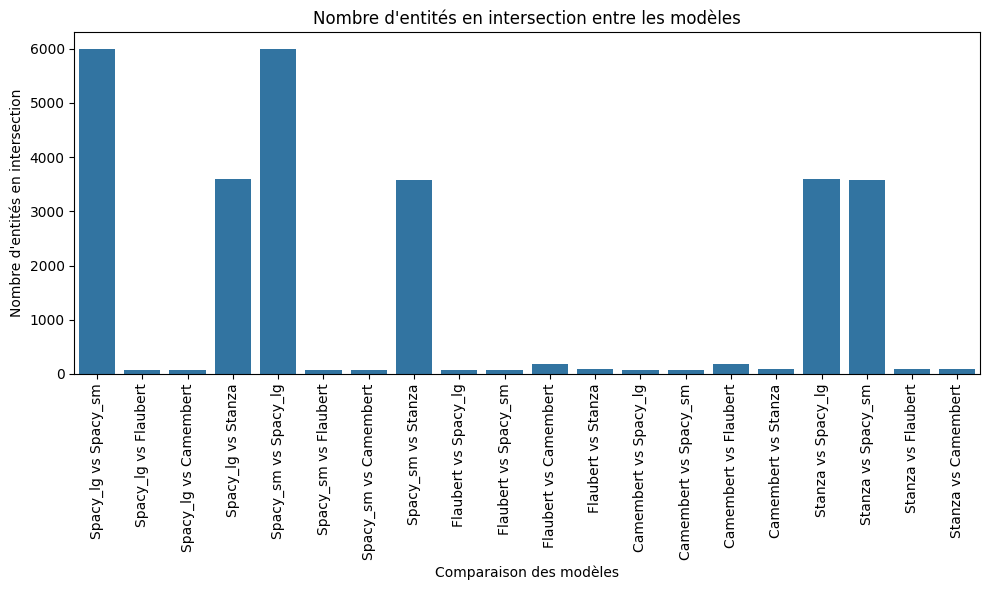

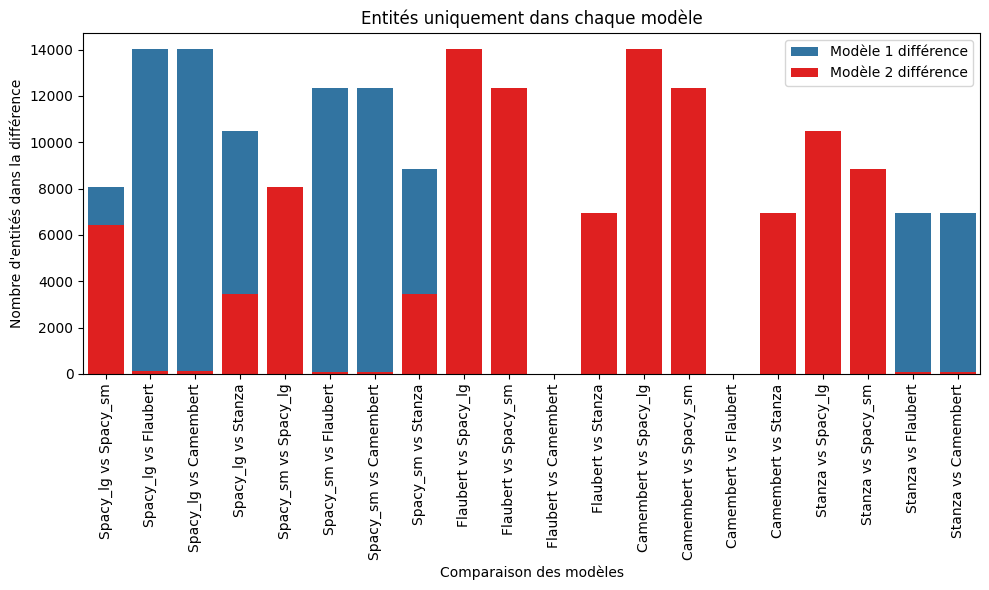

In [66]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import Counter

# Définir les chemins des fichiers
files = [
    "tous_entites_nommes_Camembert.json",
    "tous_entites_nommes_Stanza.json",
    #"tous_entites_nommes_Flaubert.json",
    #"tous_entites_nommes_Spacy_lg.json",
    # "tous_entites_nommes_Spacy_sm.json"
]

output_dir = "output_intersection_results"  # Répertoire pour enregistrer les résultats d'intersection et de différence

# Assurer que le répertoire de sortie existe
os.makedirs(output_dir, exist_ok=True)

# Charger tous les fichiers JSON et extraire les entités
entities = {}

spacy_lg_file = "tous_entites_nommes_Spacy_lg.json"
spacy_sm_file = "tous_entites_nommes_Spacy_sm.json"
# Charger Spacy_lg
with open(spacy_lg_file, "r", encoding="utf-8") as f:
    spacy_lg_data = json.load(f)
    # Extract entities from Spacy_lg for each text (e.g., "APPOLINAIRE_Caligrammes.txt")
    spacy_lg_entities = set()
    for file_name, file_data in spacy_lg_data.items():
        spacy_lg_entities.update([entite['texte'] for entite in file_data["entités nommées"]])
    entities["Spacy_lg"] = spacy_lg_entities

# Charger Spacy_sm
with open(spacy_sm_file, "r", encoding="utf-8") as f:
    spacy_sm_data = json.load(f)
    # Extract entities from Spacy_sm for each text (e.g., "APPOLINAIRE_Caligrammes.txt")
    spacy_sm_entities = set()
    for file_name, file_data in spacy_sm_data.items():
        spacy_sm_entities.update([entite['texte'] for entite in file_data["entités nommées"]])
    entities["Spacy_sm"] = spacy_sm_entities


# Charger les données Flaubert et extraire les entités
flaubert_file ="tous_entites_nommes_Flaubert.json"

with open(flaubert_file, "r", encoding="utf-8") as f:
    flaubert_data = json.load(f)
    # Extraire les entités pour chaque texte (par exemple, "APPOLINAIRE_Caligrammes.txt")
    flaubert_entities = set()
    for file_name, file_data in flaubert_data.items():
        # Extraire les entités de la clé "entités" et ajouter leurs textes dans l'ensemble
        flaubert_entities.update([entite['texte'] for entite in file_data.get("entités", [])])
    # Ajouter les entités extraites dans le dictionnaire des entités avec le nom du modèle
    entities["Flaubert"] = flaubert_entities


for file in files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        model_name = file.split("_")[-1].split(".")[0]  # Extract model name (e.g., "Camembert")

        # Traiter le format de sortie de chaque modèle
        if model_name == "Camembert" or model_name == "Stanza":
            entities[model_name] = set([entite['mot'] for entite in data["entites"]])

        #elif model_name == "Flaubert":
           #entities[model_name] = set([entite['texte'] for entite in entites])
        #elif model_name == "Spacy_lg" or model_name == "Spacy_sm":
           # entities[model_name] = set([entite['texte'] for entite in data["entités nommées"]])



# Charger Spacy_lg
with open(spacy_lg_file, "r", encoding="utf-8") as f:
    spacy_lg_data = json.load(f)
    # Extract entities from Spacy_lg for each text (e.g., "APPOLINAIRE_Caligrammes.txt")
    spacy_lg_entities = set()
    for file_name, file_data in spacy_lg_data.items():
        spacy_lg_entities.update([entite['texte'] for entite in file_data["entités nommées"]])
    entities["Spacy_lg"] = spacy_lg_entities

# Charger Spacy_sm
with open(spacy_sm_file, "r", encoding="utf-8") as f:
    spacy_sm_data = json.load(f)
    # Extract entities from Spacy_sm for each text (e.g., "APPOLINAIRE_Caligrammes.txt")
    spacy_sm_entities = set()
    for file_name, file_data in spacy_sm_data.items():
        spacy_sm_entities.update([entite['texte'] for entite in file_data["entités nommées"]])
    entities["Spacy_sm"] = spacy_sm_entities


# Calculer les intersections : transformer les données en ensembles booléens
# Récupérer toutes les entités et créer un ensemble global d'entités
all_entities = set()
for entity_set in entities.values():
    all_entities.update(entity_set)

# Créer un DataFrame booléen représentant la présence de chaque entité dans chaque modèle
boolean_data = {}
for entity in all_entities:
    boolean_data[entity] = {model_name: (entity in entity_set) for model_name, entity_set in entities.items()}

# Convertir en DataFrame, plus facile à manipuler pour d'autres visualisations
df_upset = pd.DataFrame(boolean_data).T
df_upset = df_upset.astype(bool)  # S'assurer que les données sont de type booléen

# Calculer l'intersection et la différence pour chaque paire de modèles et sauvegarder les résultats
result_data = []

# Construire un DataFrame des intersections et différences
for model_name, entity_set in entities.items():
    for compare_name, compare_set in entities.items():
        if model_name != compare_name:
            # Utiliser l'opérateur & pour calculer l'intersection
            intersection = entity_set & compare_set  # Utilisation de l'opérateur & au lieu de intersection()
            diff_model = entity_set - compare_set  # Différence
            diff_compare = compare_set - entity_set  # Différence

            result_data.append({
                "Modèle 1": model_name,
                "Modèle 2": compare_name,
                "Entités en Intersection": len(intersection),
                "Entités uniquement dans " + model_name: len(diff_model),
                "Entités uniquement dans " + compare_name: len(diff_compare)
            })

# Convertir les résultats en DataFrame
df_intersection = pd.DataFrame(result_data)

# Afficher les résultats dans la console
print(tabulate(result_data, headers="keys", tablefmt="grid"))

# Sauvegarder les résultats dans un fichier CSV
output_csv_path = os.path.join(output_dir, "intersection_results.csv")
df_intersection.to_csv(output_csv_path, index=False, encoding="utf-8")

# Sauvegarder les résultats dans un fichier Excel
output_excel_path = os.path.join(output_dir, "intersection_results.xlsx")
df_intersection.to_excel(output_excel_path, index=False)

# Visualiser les données d'intersection
# Tracer un graphique en barres pour les intersections
intersection_counts = [entry["Entités en Intersection"] for entry in result_data]
models_pair = [f"{entry['Modèle 1']} vs {entry['Modèle 2']}" for entry in result_data]

plt.figure(figsize=(10, 6))
sns.barplot(x=models_pair, y=intersection_counts)
plt.xticks(rotation=90)
plt.title("Nombre d'entités en intersection entre les modèles")
plt.xlabel("Comparaison des modèles")
plt.ylabel("Nombre d'entités en intersection")
plt.tight_layout()
plt.show()


# Tracer un graphique en barres pour les intersections
diff_model_counts = [entry["Entités uniquement dans " + entry["Modèle 1"]] for entry in result_data]
diff_compare_counts = [entry["Entités uniquement dans " + entry["Modèle 2"]] for entry in result_data]

plt.figure(figsize=(10, 6))
sns.barplot(x=models_pair, y=diff_model_counts, label='Modèle 1 différence')
sns.barplot(x=models_pair, y=diff_compare_counts, label='Modèle 2 différence', color='red')
plt.xticks(rotation=90)
plt.title("Entités uniquement dans chaque modèle")
plt.xlabel("Comparaison des modèles")
plt.ylabel("Nombre d'entités dans la différence")
plt.legend()
plt.tight_layout()
plt.show()


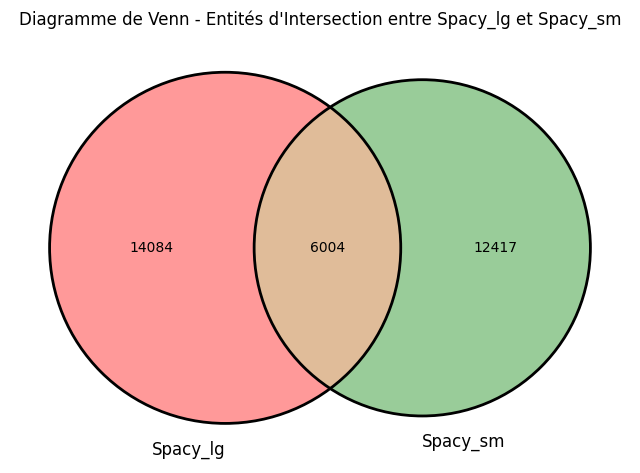

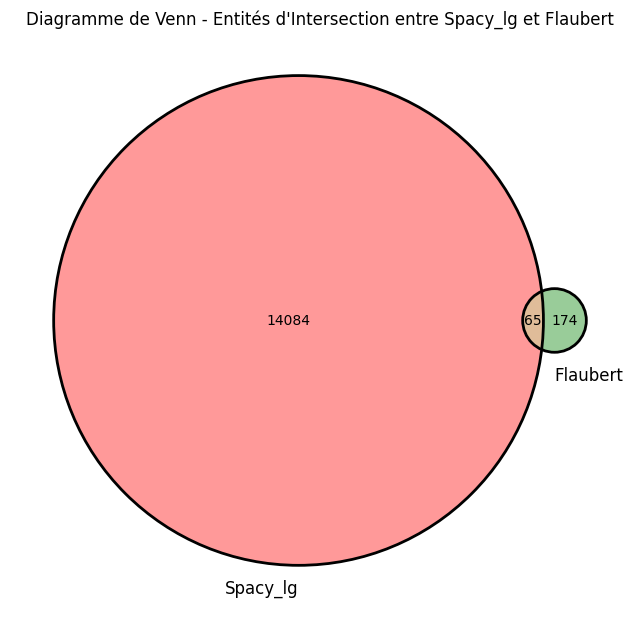

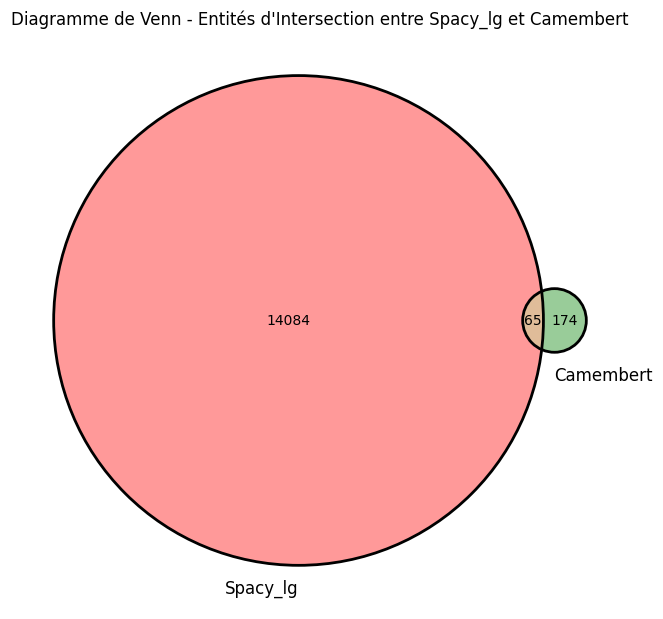

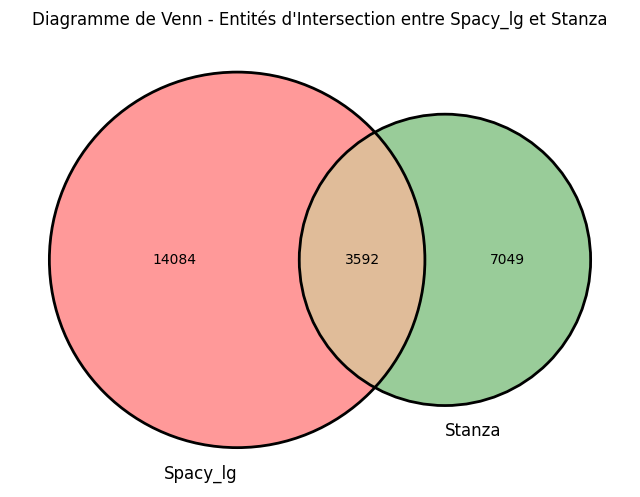

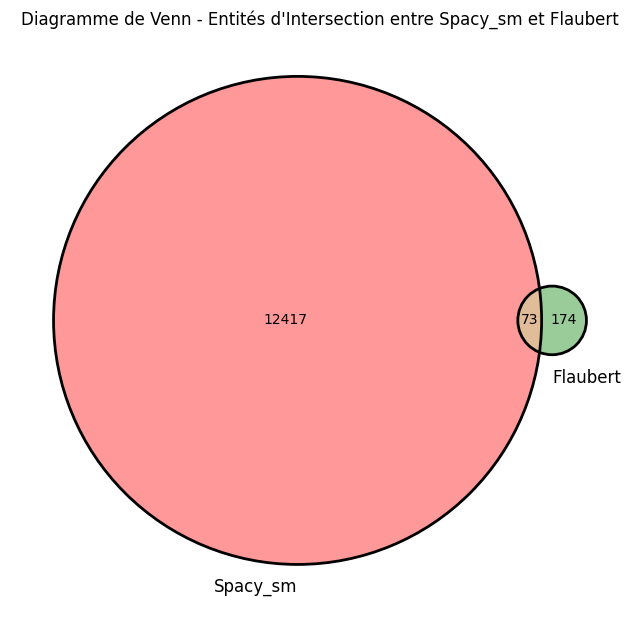

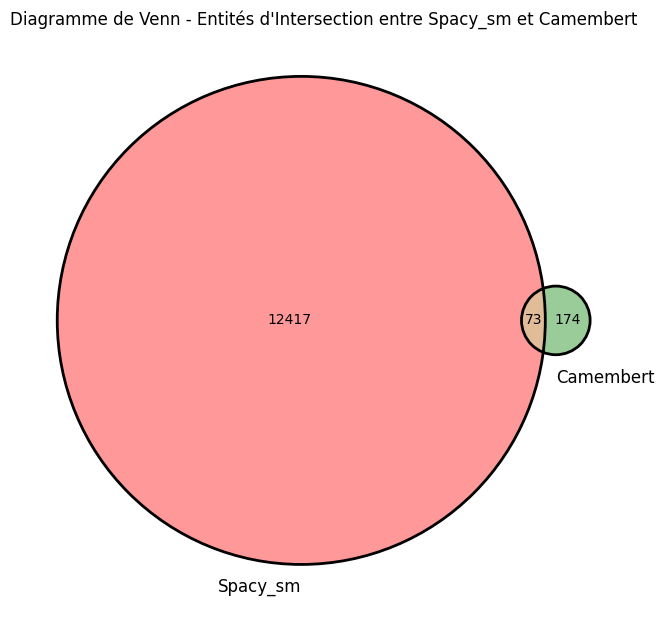

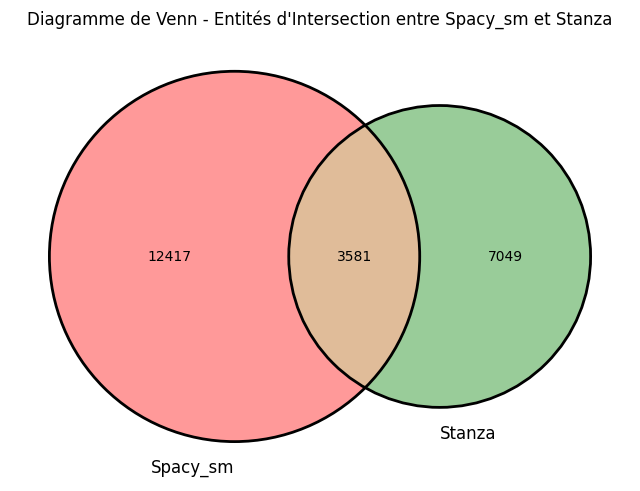

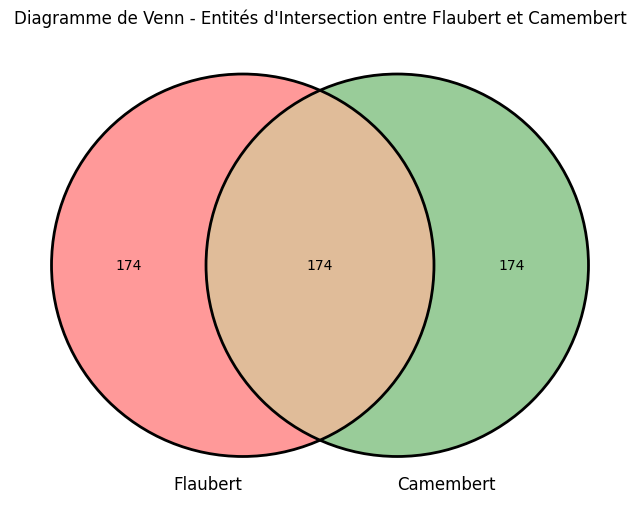

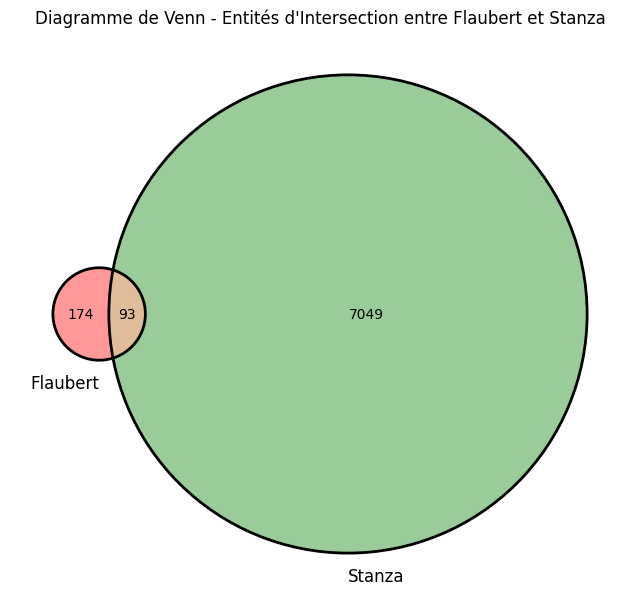

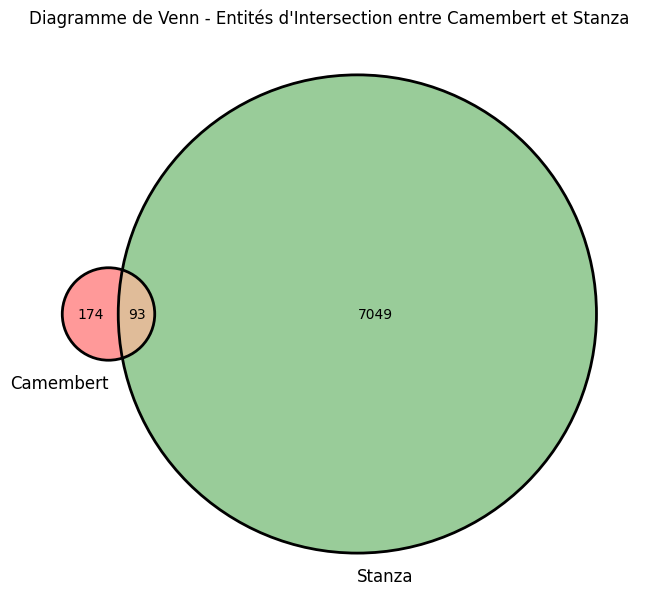

In [75]:
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import itertools
import os

# Obtenir les noms de tous les modèles
models = list(entities.keys())
output_dir = "Intersections_Globales"  # Répertoire de sortie

# Créer le répertoire de sortie (s'il n'existe pas déjà)
os.makedirs(output_dir, exist_ok=True)

# Dessiner le diagramme de Venn pour chaque paire de modèles
for model1, model2 in itertools.combinations(models, 2):
    # Obtenir l'ensemble des entités pour le modèle1 et le modèle2
    entites_model1 = entities.get(model1, set())
    entites_model2 = entities.get(model2, set())

    # Calculer l'intersection
    intersection = entites_model1 & entites_model2

    # Créer un diagramme de Venn
    plt.figure(figsize=(8, 8))

    # Dessiner le diagramme de Venn
    venn2(subsets=(len(entites_model1), len(entites_model2), len(intersection)),
         set_labels=(model1, model2))

    # Dessiner les cercles de l'intersection
    venn2_circles(subsets=(len(entites_model1), len(entites_model2), len(intersection)))

    # Définir le titre
    plt.title(f"Diagramme de Venn - Entités d'Intersection entre {model1} et {model2}")

    # Sauvegarder l'image au format PNG
    # Utiliser model1 et model2 comme partie du nom du fichier
    output_path = os.path.join(output_dir, f"Intersection entre {model1} et {model2}.png")
    plt.savefig(output_path)  # Sauvegarder en PNG
    # Afficher le diagramme
    plt.show()

    # Nettoyer la figure pour le prochain diagramme de Venn
    plt.close()


